In [211]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge,RidgeCV, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score,
    KFold,
)

from skopt import BayesSearchCV
from skopt.space import Real, Integer

from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import model_selection
from sklearn.svm import SVR
import yellowbrick.regressor as yr
from yellowbrick.model_selection import ValidationCurve, LearningCurve, RFECV, FeatureImportances

In [3]:
training_data = pd.read_csv("data/train_base.csv")
test_data = pd.read_csv("data/test_base.csv")


In [4]:
scaled_training_data = pd.read_csv("data/training_min_max_scaled.csv")
scaled_test_data = pd.read_csv("data/test_min_max_scaled.csv")

In [5]:
scaled_training_data.head()


,ID,Cycle,TTF,TTF_LABEL,S1,S2,S3,S4
0,1,1,191,0,0.309757,0.726248,0.369048,0.633262
1,1,2,190,0,0.352633,0.628019,0.380952,0.765458
2,1,3,189,0,0.370527,0.710145,0.250000,0.795309
3,1,4,188,0,0.331195,0.740741,0.166667,0.889126
4,1,5,187,0,0.404625,0.668277,0.255952,0.746269


In [4]:
test_data.head()

,ID,Cycle,S1,S2,S3,S4,TTF,TTF_LABEL
0,1,31,1398.91,554.42,47.23,521.79,112,0
1,2,49,1410.83,553.52,47.67,521.74,98,0
2,3,126,1418.89,552.59,47.88,520.83,69,0
3,4,106,1406.88,552.64,47.65,521.88,82,0
4,5,98,1419.36,553.29,47.46,521.00,91,0


In [198]:
# Define the target and features
features = ["S1", "S2", "S3", "S4", "Cycle"]
target = "TTF"


In [199]:
X_train = scaled_training_data[features]
y_train = scaled_training_data[target]

X_test = scaled_test_data[features]
y_test = scaled_test_data[target]


In [7]:
X_train.head()


,S1,S2,S3,S4
0,1400.60,554.36,47.47,521.66
1,1403.14,553.75,47.49,522.28
2,1404.20,554.26,47.27,522.42
3,1401.87,554.45,47.13,522.86
4,1406.22,554.00,47.28,522.19


In [8]:
X_test.head()


,S1,S2,S3,S4
0,1398.91,554.42,47.23,521.79
1,1410.83,553.52,47.67,521.74
2,1418.89,552.59,47.88,520.83
3,1406.88,552.64,47.65,521.88
4,1419.36,553.29,47.46,521.00


## Helper Methods

### Hyperparameter tuning

In [2]:
def tune_hyperparameters(regressor, parameters_grid, X_train, y_train, cv=5):

    """Tune the hyperparameters of a regression model using Grid Search

    Args:
        regressor (str): The model name identifier
        parameters_grid (dict): The hyperparameters grid
        X_train (dataframe): The training features
        y_train (series): The training labels
    """
    grid = GridSearchCV(regressor, parameters_grid, cv=cv)
    grid.fit(X_train, y_train)
    print(
        f"The best parameters are {grid.best_params_} with a score of {grid.best_score_}"
    )
    return grid.best_estimator_


### Model fitting and predictions

In [8]:
def train_model_and_predict(regressor, X_train, y_train, X_test):

    """Train and predict a regression model

    Args:
        regressor (str): The model name identifier
        X_train (dataframe): The training features
        y_train (series): The training labels
        X_test (dataframe): The test features
    """
    regressor.fit(X_train, y_train)
    training_predictions = regressor.predict(X_train)
    test_predictions = regressor.predict(X_test)
    return training_predictions, test_predictions


### Calculate regression metrics on training and test data for a single model
Metrics to be considered:
- RMSE
- R2 score

In [9]:
def calculate_regression_metrics(
    model_name, training_actual, training_predictions, test_actual, test_predictions
):
    """Calculate regression metrics on training and test data"""
    # Calculate training metrics
    training_r2 = r2_score(training_actual, training_predictions)
    training_rmse = np.sqrt(mean_squared_error(training_actual, training_predictions))

    # Calculate test metrics
    test_r2 = r2_score(test_actual, test_predictions)
    test_rmse = np.sqrt(mean_squared_error(test_actual, test_predictions))

    return pd.DataFrame(
        {
            f"{model_name} (Training)": {"R2": training_r2, "RMSE": training_rmse},
            f"{model_name} (Test)": {"R2": test_r2, "RMSE": test_rmse},
        }
    )


### Plot regression coefficients for a single model

In [26]:
def plot_features_weights(model, weights, feature_names, weights_type="c"):

    """Plot regression coefficients weights or feature importance.

    Args:
        model (str): The model name identifier
        weights (array): Contains the regression coefficients weights or feature importance
        feature_names (list): Contains the corresponding features names
        weights_type (str): 'c' for 'coefficients weights', otherwise is 'feature importance'

    Returns:
        plot of either regression coefficients weights or feature importance


    """
    (px, py) = (8, 10) if len(weights) > 30 else (8, 5)
    W = pd.DataFrame({"Weights": weights}, feature_names)
    W.sort_values(by="Weights", ascending=True).plot(
        kind="barh", color="r", figsize=(px, py)
    )
    label = " Coefficients" if weights_type == "c" else " Features Importance"
    plt.xlabel(model + label)
    plt.gca().legend_ = None


### Plot residuals for a single model

In [13]:
def plot_residual(model, y_train, y_train_pred, y_test, y_test_pred):

    """Print the regression residuals.

    Args:
        model (str): The model name identifier
        y_train (series): The training labels
        y_train_pred (series): Predictions on training data
        y_test (series): The test labels
        y_test_pred (series): Predictions on test data

    Returns:
        Plot of regression residuals

    """

    plt.scatter(
        y_train_pred,
        y_train_pred - y_train,
        c="blue",
        marker="o",
        label="Training data",
    )
    plt.scatter(
        y_test_pred, y_test_pred - y_test, c="lightgreen", marker="s", label="Test data"
    )
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.legend(loc="upper left")
    plt.hlines(y=0, xmin=-50, xmax=400, color="red", lw=2)
    plt.title(model + " Residuals")
    plt.show()


## Linear Regression

In [92]:
# Linear regression on base data
base_linear_regressor = LinearRegression()
training_predictions, test_predictions = train_model_and_predict(
    base_linear_regressor, training_data[features], training_data[target], test_data[features]
)


In [93]:
# Calculate metrics
base_linear_regression_metrics = calculate_regression_metrics(
    "Linear Regression Base", training_data[target], training_predictions, test_data[target], test_predictions
)
base_linear_regression_metrics

,Linear Regression Base (Training),Linear Regression Base (Test)
R2,0.644452,0.393569
RMSE,41.071267,32.360897


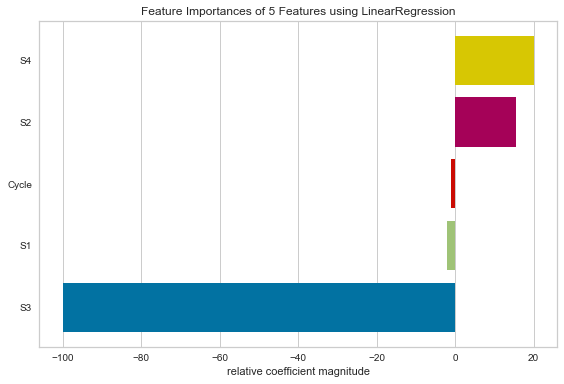

<AxesSubplot:title={'center':'Feature Importances of 5 Features using LinearRegression'}, xlabel='relative coefficient magnitude'>

In [95]:
viz= FeatureImportances(LinearRegression())
viz.fit(training_data[features], training_data[target])
viz.show()

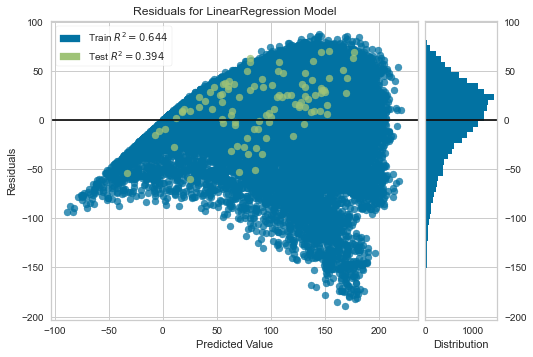

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [28]:
visualizer = yr.ResidualsPlot(LinearRegression())
visualizer.fit(training_data[features], training_data[target])
visualizer.score(test_data[features], test_data[target])
visualizer.show()

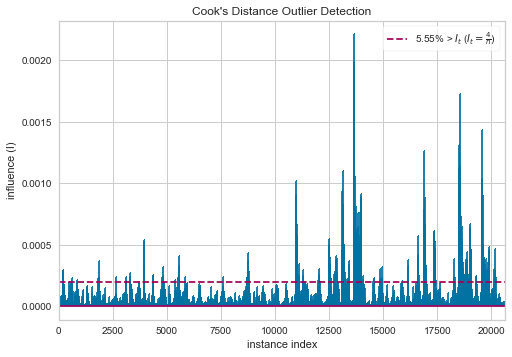

<AxesSubplot:title={'center':"Cook's Distance Outlier Detection"}, xlabel='instance index', ylabel='influence (I)'>

In [200]:
visualizer = yr.CooksDistance()
visualizer.fit(X_train, y_train)
visualizer.show()

In [201]:
i_less_influential = (visualizer.distance_ <= visualizer.influence_threshold_)
X_pruned, y_pruned = X_train[i_less_influential], y_train[i_less_influential].clip(upper=125)

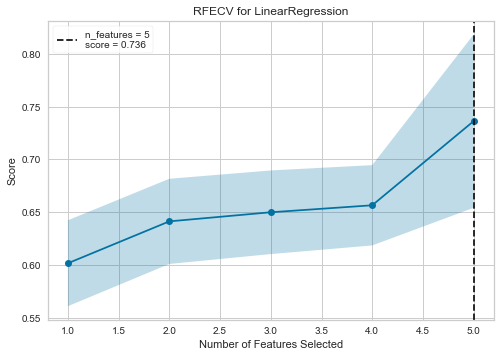

<AxesSubplot:title={'center':'RFECV for LinearRegression'}, xlabel='Number of Features Selected', ylabel='Score'>

In [100]:

visualizer = RFECV(LinearRegression())         # Finalize and render the figure
visualizer.fit(X_pruned, y_pruned)        # Fit the data to the visualizer
visualizer.show()  

In [87]:
# Linear regression on normalized data + without outliers + with clipping
linear_regressor = LinearRegression()
training_predictions, test_predictions = train_model_and_predict(
    linear_regressor, X_pruned, y_pruned, X_test
)

In [88]:
# Calculate metrics
linear_regression_metrics = calculate_regression_metrics(
    "Linear Regression", y_pruned, training_predictions, y_test, test_predictions
)
linear_regression_metrics


,Linear Regression (Training),Linear Regression (Test)
R2,0.662909,0.665077
RMSE,24.281677,24.049306


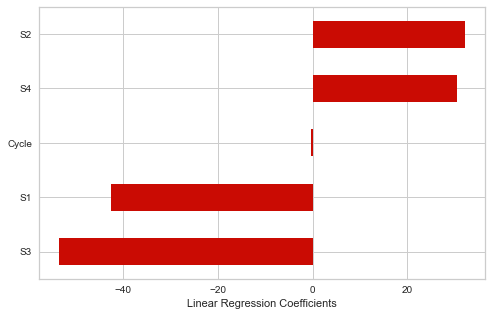

In [27]:
plot_features_weights("Linear Regression", linear_regressor.coef_, features, "c")


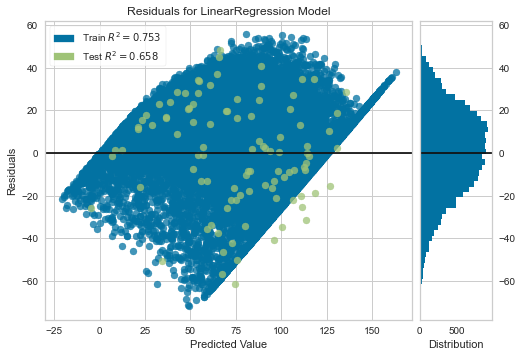

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [29]:
visualizer = yr.ResidualsPlot(LinearRegression())
visualizer.fit(X_pruned, y_pruned)
visualizer.score(X_test, y_test)
visualizer.show()

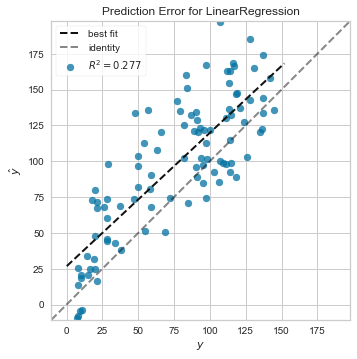

<AxesSubplot:title={'center':'Prediction Error for LinearRegression'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [21]:
visualizer = yr.PredictionError(LinearRegression())
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

In [35]:
# Compare with base linear regression
pd.concat([base_linear_regression_metrics, linear_regression_metrics], axis=1)

,Linear Regression Base (Training),Linear Regression Base (Test),Linear Regression (Training),Linear Regression (Test)
R2,0.644452,0.393569,0.753062,0.657937
RMSE,41.071267,32.360897,20.714950,24.304287


In [111]:
(24.304287 - 21.401) / 21.401

0.13566127751039667

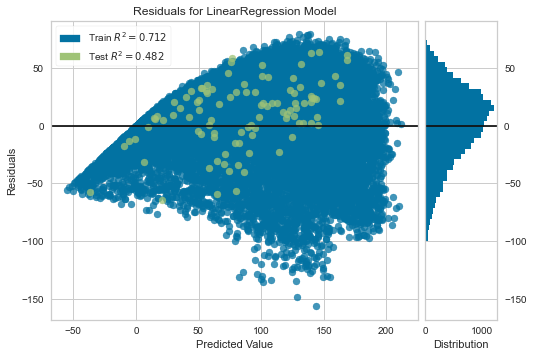

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [11]:
model = LinearRegression()
visualizer_residuals = yr.ResidualsPlot(model)
visualizer_residuals.fit(X_li, y_li)
visualizer_residuals.score(X_test, y_test)
visualizer_residuals.show()

In [12]:
# Calculate metrics
linear_regression_metrics = calculate_regression_metrics(
    "Linear Regression", y_li, model.predict(X_li), y_test, model.predict(X_test)
)
linear_regression_metrics


,Linear Regression (Training),Linear Regression (Test)
R2,0.712238,0.481822
RMSE,33.644713,29.913653


In [28]:
# Linear regression
linear_regressor = LinearRegression()
training_predictions, test_predictions = train_model_and_predict(
    linear_regressor, X_li, y_pruned, X_test
)

In [29]:
# Calculate metrics
linear_regression_metrics = calculate_regression_metrics(
    "Linear Regression", y_pruned, training_predictions, y_test, test_predictions
)
linear_regression_metrics


,Linear Regression (Training),Linear Regression (Test)
R2,0.753062,0.657937
RMSE,20.714950,24.304287


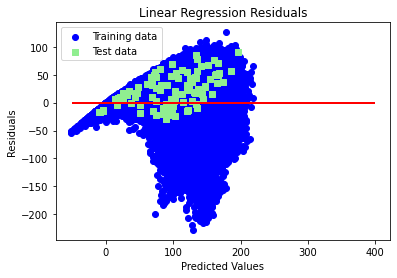

In [17]:
plot_residual(
    "Linear Regression",
    training_data[target],
    training_predictions,
    test_data[target],
    test_predictions,
)


### Lasso Regression

In [14]:
# Define hyperparameter space and identify the best hyperparameters
grid_space = np.linspace(0.00001, 1, 10)
parameters_grid = {"alpha": grid_space}
tuned_lasso_regressor = tune_hyperparameters(Lasso(), parameters_grid, X_train, y_train)


The best parameters are {'alpha': 1e-05} with a score of 0.6314015166415815


In [ ]:
def on_step(optim_result):
    """
    Callback meant to view scores after
    each iteration while performing Bayesian
    Optimization in Skopt"""
    score = forest_bayes_search.best_score_
    print("best score: %s" % score)
    if score >= 0.98:
        print('Interrupting!')
        return True

In [37]:
# Define hyperparameter space and identify the best hyperparameters
alpha_space = Real(0.00001, 1)
search_space = {"alpha": alpha_space}
lasso_regressor = Lasso()
tuned_lasso_regressor = BayesSearchCV(lasso_regressor, search_space, cv=5, n_iter=32)
tuned_lasso_regressor.fit(X_train, y_train)

/Users/tanmayk/.pyenv/versions/3.9.1/envs/SLM-Code/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


In [34]:
# Make predictions on training and test data
training_predictions = tuned_lasso_regressor.predict(X_train)
test_predictions = tuned_lasso_regressor.predict(X_test)

NotFittedError: This BayesSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
# Calculate metrics
lasso_regression_metrics = calculate_regression_metrics(
    "Lasso Regression", y_train, training_predictions, y_test, test_predictions
)
lasso_regression_metrics


In [27]:
# Calculate metrics
lasso_regression_metrics = calculate_regression_metrics(
    "Lasso Regression", y_train, training_predictions, y_test, test_predictions
)
lasso_regression_metrics


,Lasso Regression (Training),Lasso Regression (Test)
R2,0.530703,0.277052
RMSE,47.185977,35.333227


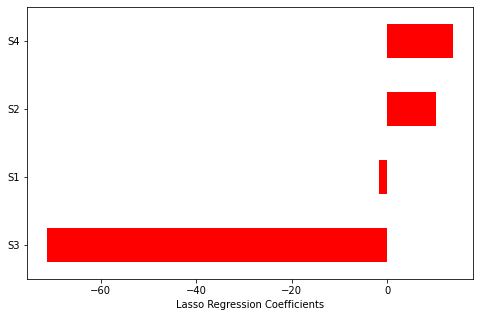

In [28]:
plot_features_weights("Lasso Regression", tuned_lasso_regressor.coef_, features, "c")


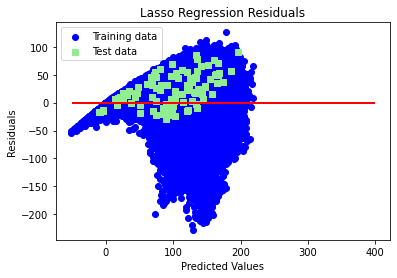

In [30]:
plot_residual(
    "Lasso Regression", y_train, training_predictions, y_test, test_predictions
)


### Ridge Regression

In [15]:
alpha_space = [0.001, 0.01, 0.1, 1, 10]

In [31]:
# Perform grid search for Ridge regression
parameters_grid = {"alpha": alpha_space}
tuned_ridge_regressor = tune_hyperparameters(Ridge(), parameters_grid, X_train, y_train)

The best parameters are {'alpha': 10} with a score of 0.5171209171741322


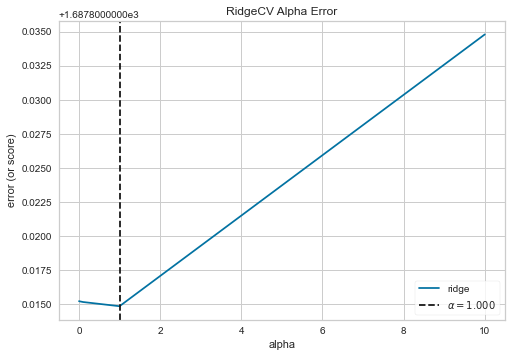

<AxesSubplot:title={'center':'RidgeCV Alpha Error'}, xlabel='alpha', ylabel='error (or score)'>

In [16]:
visualizer = AlphaSelection(RidgeCV(alphas=alpha_space))
visualizer.fit(X_train, y_train)
visualizer.show()

False

In [33]:
# Make predictions on training and test data
training_predictions = tuned_ridge_regressor.predict(X_train)
test_predictions = tuned_ridge_regressor.predict(X_test)


In [34]:
# Calculate metrics
ridge_regression_metrics = calculate_regression_metrics(
    "Ridge Regression", y_train, training_predictions, y_test, test_predictions
)
ridge_regression_metrics


,Ridge Regression (Training),Ridge Regression (Test)
R2,0.530687,0.276352
RMSE,47.186737,35.350329


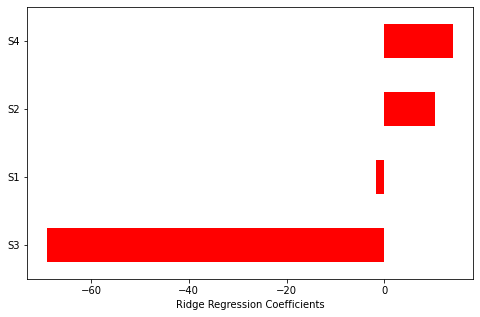

In [35]:
# Plot features weights
plot_features_weights("Ridge Regression", tuned_ridge_regressor.coef_, features, "c")


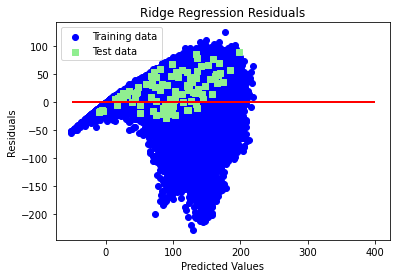

In [36]:
# Plot residuals
plot_residual(
    "Ridge Regression", y_train, training_predictions, y_test, test_predictions
)


## Elastic Net Regression

In [12]:
# Perform grid search for Elastic Net regression
alpha_space = [0.001, 0.05, 0.1]
l1_ratio_space = [0.5, 0.6, 0.9]
parameters_grid = {"alpha": alpha_space, "l1_ratio": l1_ratio_space}
tuned_elastic_net_regressor = tune_hyperparameters(
    ElasticNet(), parameters_grid, X_train, y_train
)


The best parameters are {'alpha': 0.001, 'l1_ratio': 0.6} with a score of 0.63144967001454


In [13]:
# Make predictions on training and test data
training_predictions = tuned_elastic_net_regressor.predict(X_train)
test_predictions = tuned_elastic_net_regressor.predict(X_test)


In [14]:
# Calculate metrics
elastic_net_regression_metrics = calculate_regression_metrics(
    "Elastic Net Regression", y_train, training_predictions, y_test, test_predictions
)
elastic_net_regression_metrics


,Elastic Net Regression (Training),Elastic Net Regression (Test)
R2,0.644439,0.392812
RMSE,41.071983,32.381083


## Polynomial Regression

In [40]:
# Perform search for best degree of polynomial regression
degree_space = [2, 3, 4, 5]
best_score = 0
best_degree = 0

for degree in degree_space:
    poly_features = PolynomialFeatures(degree=degree)
    X_train_poly = poly_features.fit_transform(training_data[features])
    polynomial_regressor = LinearRegression()
    polynomial_regressor.fit(X_train_poly, training_data[target])
    scores = cross_val_score(
        polynomial_regressor, X_train_poly, training_data[target], cv=5
    )  # Change k-fold cv value here
    if np.mean(scores) > best_score:
        best_score = np.mean(scores)
        best_degree = degree


In [41]:
best_degree

5

In [105]:
# Create polynomial features
poly_features = PolynomialFeatures(degree=4)
X_train_poly = poly_features.fit_transform(X_pruned)
X_test_poly = poly_features.fit_transform(X_test)

In [106]:
# Fit polynomial regression model and make predictions
polynomial_regressor = LinearRegression()
training_predictions, test_predictions = train_model_and_predict(
    polynomial_regressor, X_train_poly, y_pruned, X_test_poly
)

In [41]:
# Calculate metrics
polynomial_regression_metrics = calculate_regression_metrics(
    "Polynomial Regression", y_pruned, training_predictions, y_test, test_predictions
)
polynomial_regression_metrics


,Polynomial Regression (Training),Polynomial Regression (Test)
R2,0.818386,0.714512
RMSE,17.765009,22.203597


In [15]:
# Calculate metrics - 2
polynomial_regression_metrics = calculate_regression_metrics(
    "Polynomial Regression", y_pruned, training_predictions, y_test, test_predictions
)
polynomial_regression_metrics


,Polynomial Regression (Training),Polynomial Regression (Test)
R2,0.788498,0.705136
RMSE,19.171105,22.565281


In [24]:
# Calculate metrics - 3
polynomial_regression_metrics = calculate_regression_metrics(
    "Polynomial Regression", y_pruned, training_predictions, y_test, test_predictions
)
polynomial_regression_metrics


,Polynomial Regression (Training),Polynomial Regression (Test)
R2,0.807640,0.711227
RMSE,18.283001,22.331014


In [108]:
# Calculate metrics - 4
polynomial_regression_metrics = calculate_regression_metrics(
    "Polynomial Regression", y_pruned, training_predictions, y_test, test_predictions
)
polynomial_regression_metrics

,Polynomial Regression (Training),Polynomial Regression (Test)
R2,0.811627,0.734766
RMSE,18.098745,21.401504


In [109]:
# Calculate metrics - 5
polynomial_regression_metrics = calculate_regression_metrics(
    "Polynomial Regression", y_pruned, training_predictions, y_test, test_predictions
)
polynomial_regression_metrics


,Polynomial Regression (Training),Polynomial Regression (Test)
R2,0.811627,0.734766
RMSE,18.098745,21.401504


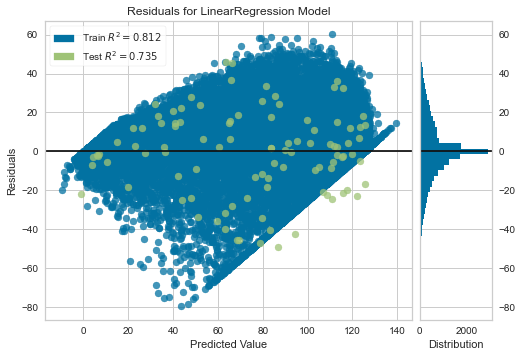

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [112]:
visualizer = yr.ResidualsPlot(LinearRegression())
visualizer.fit(X_train_poly, y_pruned)
visualizer.score(X_test_poly, y_test)
visualizer.show()

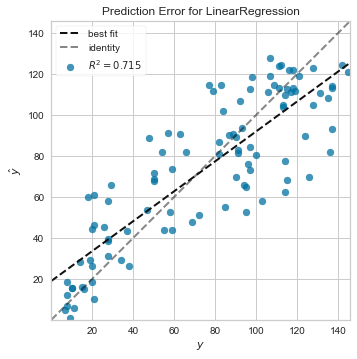

<AxesSubplot:title={'center':'Prediction Error for LinearRegression'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [43]:
visualizer = yr.PredictionError(LinearRegression())
visualizer.fit(X_train_poly, y_pruned)
visualizer.score(X_test_poly, y_test)
visualizer.show()

## Decision Tree Regression

In [53]:
# Perform grid search for Decision Tree regression
parameters_grid = {"max_depth": [4, 5, 6, 7, 8, 9]}
decision_tree_regressor = tune_hyperparameters(
    DecisionTreeRegressor(), parameters_grid, X_train, y_train
)


The best parameters are {'max_depth': 6} with a score of 0.5006656819431712


In [54]:
# Make predictions on training and test data
training_predictions = decision_tree_regressor.predict(X_train)
test_predictions = decision_tree_regressor.predict(X_test)


In [55]:
# Calculate metrics
decision_tree_regression_metrics = calculate_regression_metrics(
    "Decision Tree Regression", y_train, training_predictions, y_test, test_predictions
)
decision_tree_regression_metrics


,Decision Tree Regression (Training),Decision Tree Regression (Test)
R2,0.545733,0.233683
RMSE,46.424204,36.377606


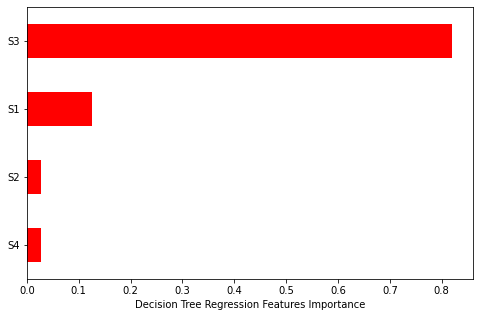

In [58]:
# Plot features weights
plot_features_weights(
    "Decision Tree Regression",
    decision_tree_regressor.feature_importances_,
    features,
    "t",
)


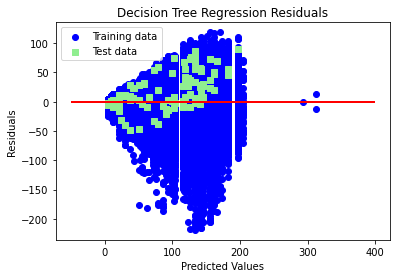

In [57]:
# Plot residuals
plot_residual(
    "Decision Tree Regression", y_train, training_predictions, y_test, test_predictions
)


## Random Forest Regression

In [41]:
# Perform grid search for Random Forest regression
estimators_space = [60, 70, 80, 90, 100]
features_space = [2, 3, 4, 5]
depth_space = [4, 5, 6, 7, 8, 9]

parameters_grid = {
    "n_estimators": estimators_space,
    "max_features": features_space,
    "max_depth": depth_space,
}
random_forest_regressor = tune_hyperparameters(
    RandomForestRegressor(), parameters_grid, X_train, y_train
)


The best parameters are {'max_depth': 6, 'max_features': 3, 'n_estimators': 60} with a score of 0.688130124295941


In [225]:
# Test random forest model
random_forest_regressor = RandomForestRegressor(
    n_estimators=60, max_features=5, max_depth=6
)
random_forest_regressor.fit(X_pruned, y_pruned)


RandomForestRegressor(max_depth=6, max_features=5, n_estimators=60)

In [226]:
# Make predictions on training and test data
training_predictions = random_forest_regressor.predict(X_pruned)
test_predictions = random_forest_regressor.predict(X_test)


In [189]:
# Calculate metrics - s1, s3 and cycle
random_forest_regression_metrics = calculate_regression_metrics(
    "Random Forest Regression", y_pruned, training_predictions, y_test, test_predictions
)
random_forest_regression_metrics


,Random Forest Regression (Training),Random Forest Regression (Test)
R2,0.832267,0.725425
RMSE,17.078416,21.775108


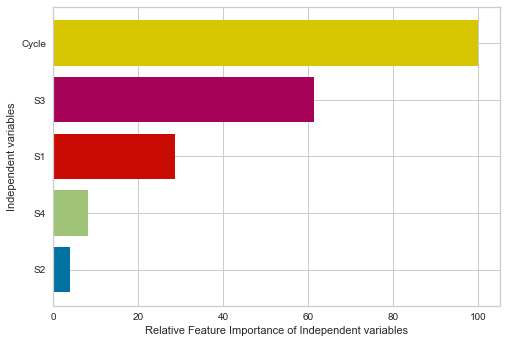

In [233]:
viz= FeatureImportances(RandomForestRegressor(
    n_estimators=70, max_features=3, max_depth=8
))
viz.fit(X_pruned, y_pruned)
viz.ax.set_xlabel("Relative Feature Importance of Independent variables")
viz.ax.set_ylabel("Independent variables")

plt.show()

Optimal number of features : 5
The selected features are: ['S1', 'S2', 'S3', 'S4', 'Cycle']


AttributeError: 'RFE' object has no attribute 'grid_scores_'

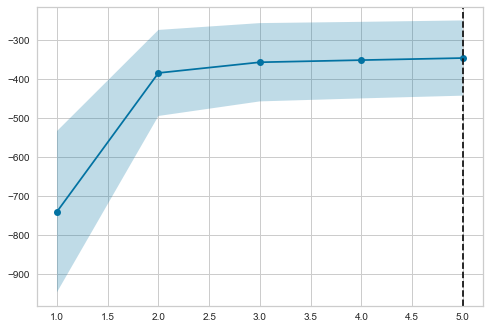

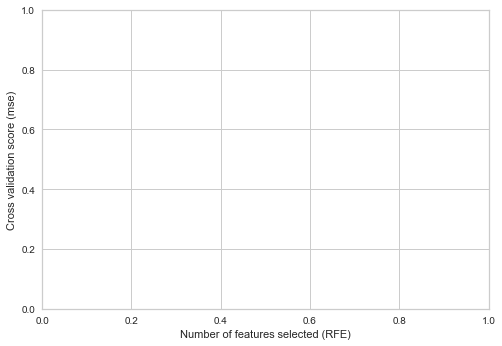

In [213]:
kfold = model_selection.KFold(n_splits=5)

dtrg = RandomForestRegressor(max_depth=6)

rfecv = RFECV(estimator=dtrg, step=1, cv=kfold, scoring='neg_mean_squared_error', n_jobs=-1)
rfecv.fit(X_pruned, y_pruned)

print("Optimal number of features : %d" % rfecv.n_features_)

sel_features = [f for f,s in zip(X_train.columns, rfecv.support_) if s]
print('The selected features are: {}'.format(sel_features))

# Plot number of features VS. cross-validation scores


In [224]:
rfecv.ranking_

array([1, 1, 1, 1, 1])

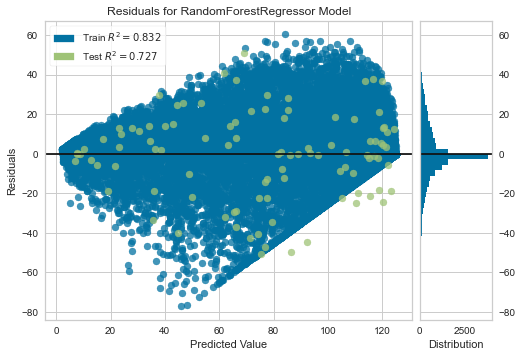

<AxesSubplot:title={'center':'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [116]:
visualizer = yr.ResidualsPlot(RandomForestRegressor(
    n_estimators=70, max_features=2, max_depth=8
))
visualizer.fit(X_pruned, y_pruned)
visualizer.score(X_test, y_test)
visualizer.show()

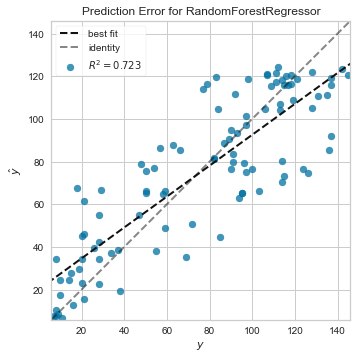

<AxesSubplot:title={'center':'Prediction Error for RandomForestRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [117]:
visualizer = yr.PredictionError(RandomForestRegressor(
    n_estimators=70, max_features=2, max_depth=8
))
visualizer.fit(X_pruned, y_pruned)
visualizer.score(X_test, y_test)
visualizer.show()

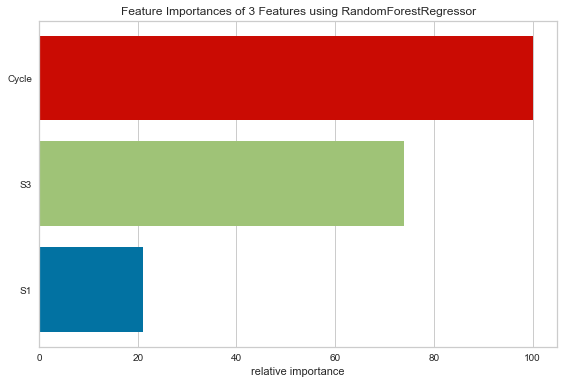

<AxesSubplot:title={'center':'Feature Importances of 3 Features using RandomForestRegressor'}, xlabel='relative importance'>

In [118]:
viz= FeatureImportances(RandomForestRegressor(
    n_estimators=70, max_features=2, max_depth=8
))
viz.fit(X_pruned, y_pruned)
viz.show()

In [47]:
# Calculate metrics
random_forest_regression_metrics = calculate_regression_metrics(
    "Random Forest Regression", y_pruned, training_predictions, y_test, test_predictions
)
random_forest_regression_metrics


,Random Forest Regression (Training),Random Forest Regression (Test)
R2,0.824853,0.726732
RMSE,17.445823,21.723231


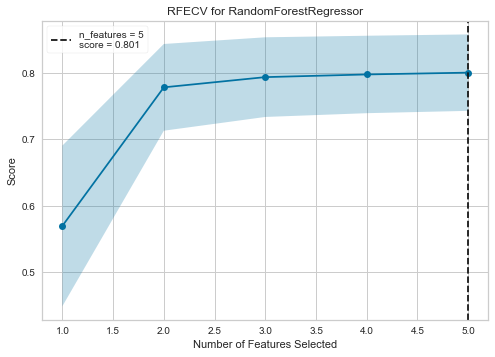

<AxesSubplot:title={'center':'RFECV for RandomForestRegressor'}, xlabel='Number of Features Selected', ylabel='Score'>

In [63]:

visualizer = RFECV(RandomForestRegressor(
    n_estimators=60, max_depth=6
))         # Finalize and render the figure
visualizer.fit(X_pruned, y_pruned)        # Fit the data to the visualizer
visualizer.show()  

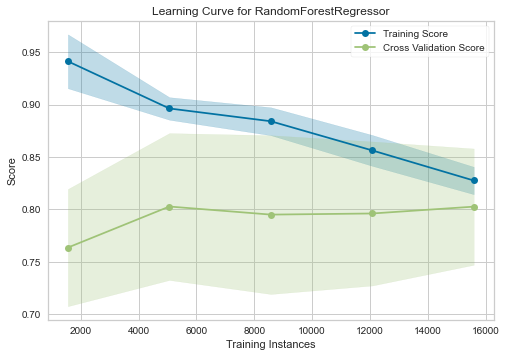

<AxesSubplot:title={'center':'Learning Curve for RandomForestRegressor'}, xlabel='Training Instances', ylabel='Score'>

In [53]:
visualizer = LearningCurve(RandomForestRegressor(
    n_estimators=60, max_features=3, max_depth=6
), scoring='r2')
visualizer.fit(X_pruned, y_pruned)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

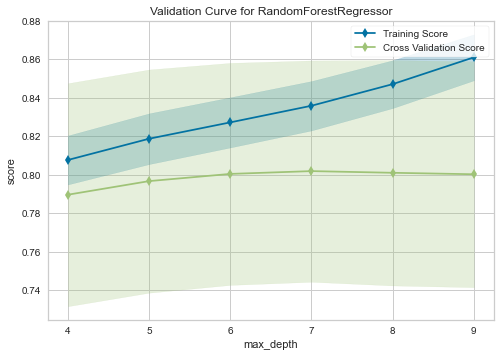

<AxesSubplot:title={'center':'Validation Curve for RandomForestRegressor'}, xlabel='max_depth', ylabel='score'>

In [55]:
viz = ValidationCurve(
    RandomForestRegressor(), param_name="max_depth",
    param_range=[4, 5, 6, 7, 8, 9], cv=5, scoring="r2"
)
viz.fit(X_pruned, y_pruned)
viz.show()

In [37]:
# Calculate metrics
random_forest_regression_metrics = calculate_regression_metrics(
    "Random Forest Regression", y_train, training_predictions, y_test, test_predictions
)
random_forest_regression_metrics


,Random Forest Regression (Training),Random Forest Regression (Test)
R2,0.712324,0.570846
RMSE,36.943743,27.223014


In [65]:
# Calculate metrics
random_forest_regression_metrics = calculate_regression_metrics(
    "Random Forest Regression", y_train, training_predictions, y_test, test_predictions
)
random_forest_regression_metrics


,Random Forest Regression (Training),Random Forest Regression (Test)
R2,0.555365,0.302544
RMSE,45.929375,34.704698


In [71]:
# Calculate metrics
random_forest_regression_metrics = calculate_regression_metrics(
    "Random Forest Regression", y_train, training_predictions, y_test, test_predictions
)
random_forest_regression_metrics


,Random Forest Regression (Training),Random Forest Regression (Test)
R2,0.539903,0.310415
RMSE,46.721170,34.508307


In [33]:
# Calculate metrics - Clipped
random_forest_regression_metrics = calculate_regression_metrics(
    "Random Forest Regression", y_pruned, training_predictions, y_test, test_predictions
)
random_forest_regression_metrics


,Random Forest Regression (Training),Random Forest Regression (Test)
R2,0.824806,0.725995
RMSE,17.448150,21.752483


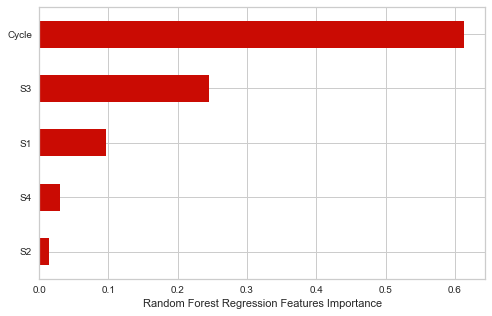

In [38]:
# Plot features weights
plot_features_weights(
    "Random Forest Regression",
    random_forest_regressor.feature_importances_,
    features,
    "t",
)


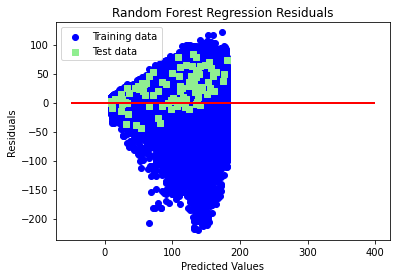

In [73]:
# Plot residuals
plot_residual(
    "Random Forest Regression", y_train, training_predictions, y_test, test_predictions
)


## Random Forest Regression with Gradient Boosting

In [36]:
search_grid={'n_estimators':[500,1000,2000],'learning_rate':[.001,0.01,.1],'max_depth':[1,2,4],'subsample':[.5,.75,1],'random_state':[1]}
gb_random_forest_regressor = GradientBoostingRegressor(random_state=42)
gb_random_forest_regressor.fit(X_li, y_pruned)
training_predictions = gb_random_forest_regressor.predict(X_li)
test_predictions = gb_random_forest_regressor.predict(X_test)

In [38]:
# Calculate metrics
gb_random_forest_regression_metrics = calculate_regression_metrics(
    "Random Forest Regression", y_pruned, training_predictions, y_test, test_predictions
)
gb_random_forest_regression_metrics


,Random Forest Regression (Training),Random Forest Regression (Test)
R2,0.824268,0.724810
RMSE,17.474941,21.799467


## Support Vector Regression

In [41]:
# Define SVR model
svr_regressor = SVR(kernel="linear")

# Fit SVR model and make predictions
training_predictions, test_predictions = train_model_and_predict(
    svr_regressor, X_train_poly, y_pruned, X_test_poly
)


In [43]:
# Calculate metrics
svr_regression_metrics = calculate_regression_metrics(
    "SVR Regression", y_pruned, training_predictions, y_test, test_predictions
)
svr_regression_metrics


,SVR Regression (Training),SVR Regression (Test)
R2,-0.329725,-0.772472
RMSE,48.069682,55.324756


In [17]:
# Calculate metrics
svr_regression_metrics = calculate_regression_metrics(
    "SVR Regression", y_pruned, training_predictions, y_test, test_predictions
)
svr_regression_metrics


,SVR Regression (Training),SVR Regression (Test)
R2,0.750768,0.643588
RMSE,20.810982,24.808813


In [ ]:
# Calculate metrics - Poly + Clipped
svr_regression_metrics = calculate_regression_metrics(
    "SVR Regression - Poly", y_pruned, training_predictions, y_test, test_predictions
)
svr_regression_metrics


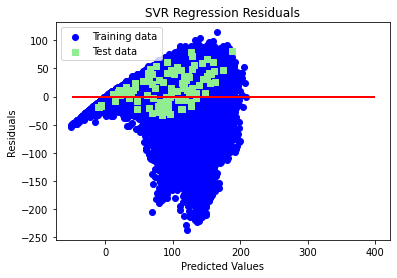

In [88]:
# Plot residuals
plot_residual("SVR Regression", y_train, training_predictions, y_test, test_predictions)


## Comparison of Regression Algorithms

In [148]:
metrics = pd.concat(
    [
        linear_regression_metrics,
        polynomial_regression_metrics,
        random_forest_regression_metrics,
    ],
    axis=1,
)
test_metrics = metrics.filter(like="(Test)", axis=1)
metrics

,Linear Regression (Training),Linear Regression (Test),Polynomial Regression (Training),Polynomial Regression (Test),Random Forest Regression (Training),Random Forest Regression (Test)
R2,0.662909,0.665077,0.811627,0.734766,0.832458,0.726889
RMSE,24.281677,24.049306,18.098745,21.401504,17.068725,21.716963


In [166]:
metrics_t = metrics.transpose()
metrics_t['label'] = metrics_t.apply(lambda x: 'Test' if 'Test' in x.name else 'Training', axis=1)
metrics_t['model'] = ['Linear Regression', 'Linear Regression', 'Polynomial Regression','Polynomial Regression', 'Random Forest Regression', 'Random Forest Regression']

metrics_t

,R2,RMSE,label,model
Linear Regression (Training),0.662909,24.281677,Training,Linear Regression
Linear Regression (Test),0.665077,24.049306,Test,Linear Regression
Polynomial Regression (Training),0.811627,18.098745,Training,Polynomial Regression
Polynomial Regression (Test),0.734766,21.401504,Test,Polynomial Regression
Random Forest Regression (Training),0.832458,17.068725,Training,Random Forest Regression
Random Forest Regression (Test),0.726889,21.716963,Test,Random Forest Regression


Text(0, 0.5, 'R2 score')

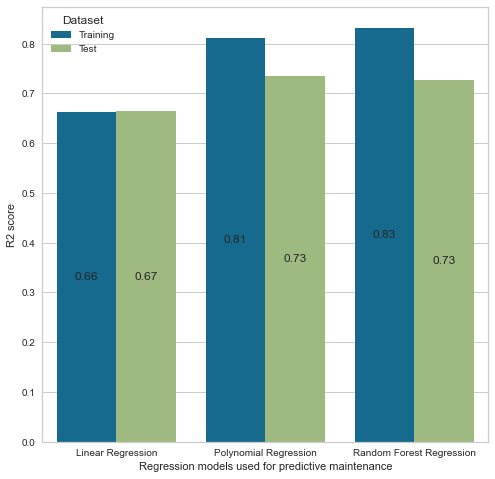

In [185]:
plt.figure(figsize=(8, 8))
ax = sns.barplot(x=metrics_t.model, y=metrics_t.R2, hue=metrics_t.label)
plt.legend(title='Dataset')
for p in ax.patches:
    h, w, x = p.get_height(), p.get_width(), p.get_x()
    xy = (x + w / 2., h / 2)
    text = f'{h:0.2f}'
    ax.annotate(text=text, xy=xy, ha='center', va='center')
ax.set_xlabel('Regression models used for predictive maintenance')
ax.set_ylabel('R2 score')

Text(0, 0.5, 'Root mean squared error')

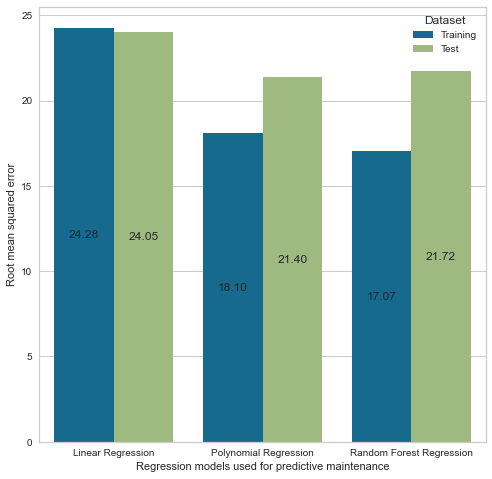

In [186]:
plt.figure(figsize=(8, 8))
ax = sns.barplot(x=metrics_t.model, y=metrics_t.RMSE, hue=metrics_t.label)
plt.legend(title='Dataset')
for p in ax.patches:
    h, w, x = p.get_height(), p.get_width(), p.get_x()
    xy = (x + w / 2., h / 2)
    text = f'{h:0.2f}'
    ax.annotate(text=text, xy=xy, ha='center', va='center')

ax.set_xlabel('Regression models used for predictive maintenance')
ax.set_ylabel('Root mean squared error')